<a href="https://colab.research.google.com/github/praveenpareek11/RNA-Seq/blob/master/run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install cmapPy

In [0]:
'''Import necessary libraries'''
import random

In [0]:
from cmapPy.pandasGEXpress.parse import parse
from matplotlib import colors as mcolors
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [0]:
'''Read the dataset'''
data = parse('/content/drive/My Drive/Colab Notebooks/data/PAAD.gct', convert_neg_666=True)

In [6]:
print(data)

GCT1.3
src: /content/drive/My Drive/Colab Notebooks/data/PAAD.gct
data_df: [18465 rows x 183 columns]
row_metadata_df: [18465 rows x 0 columns]
col_metadata_df: [183 rows x 124 columns]


So the above output shows that the GCT file has three dataframes in it.
The parse function of cmapPy library is used to read the filetype GCT/GCTX. It converts the data into "GCToo" object, which is further explained. The three dataframes are described below. We'll use this in our further analysis of the RNA-Seq data.

These are:
- **data_df:** It has 18465 rows (Gene ID) abd 183 columns (Sample Name/ID)
- **row_metadata_df:** It has row metadata and When we see the type, It is empty dataframe. This means in our data, the row metadata is not present.
- **col_metadata_df:** It has 183 columns (Sample Names/ID) and 124 rows (Column metadata like histological_type, Patient_ID, status(is he alive or not)) for each sample.

In [0]:
#Renaming the dataframes for convenience.
data_df = data.data_df
row_metadata_df = data.row_metadata_df
col_metadata_df = data.col_metadata_df

In [8]:
#Get a first insight of the 1st dataframe. It has RNA ID as index and the Sample Name as the name of columns.
data_df.head(5)

cid,aab1-Primary solid Tumor,aab4-Primary solid Tumor,aab6-Primary solid Tumor,aab8-Primary solid Tumor,aab9-Primary solid Tumor,aaba-Primary solid Tumor,aabe-Primary solid Tumor,aabf-Primary solid Tumor,aabh-Primary solid Tumor,aabi-Primary solid Tumor,aabk-Primary solid Tumor,aabo-Primary solid Tumor,aabp-Primary solid Tumor,aabr-Primary solid Tumor,aabt-Primary solid Tumor,aabu-Primary solid Tumor,aabv-Primary solid Tumor,aaqa-Primary solid Tumor,aaqe-Primary solid Tumor,aaqi-Primary solid Tumor,aaqj-Primary solid Tumor,aaql-Primary solid Tumor,aaqm-Primary solid Tumor,a9i5-Primary solid Tumor,a9i7-Primary solid Tumor,a9i9-Primary solid Tumor,a9ib-Primary solid Tumor,a9ic-Primary solid Tumor,a9ih-Primary solid Tumor,a9ij-Primary solid Tumor,a9il-Primary solid Tumor,a9in-Primary solid Tumor,a9io-Primary solid Tumor,a9ir-Primary solid Tumor,a9is-Primary solid Tumor,a9iu-Primary solid Tumor,a9iv-Primary solid Tumor,a9ix-Primary solid Tumor,a9iz-Primary solid Tumor,a9j0-Primary solid Tumor,...,aaup-Primary solid Tumor,aauq-Primary solid Tumor,aaur-Primary solid Tumor,aaus-Primary solid Tumor,aaut-Primary solid Tumor,aauu-Primary solid Tumor,aauv-Primary solid Tumor,aauw-Primary solid Tumor,a7w4-Primary solid Tumor,a7sx-Primary solid Tumor,a8f3-Primary solid Tumor,a9q5-Primary solid Tumor,a5n4-Primary solid Tumor,a75w-Primary solid Tumor,a5re-Primary solid Tumor,a5qy-Primary solid Tumor,aa2a-Primary solid Tumor,a7b8-Primary solid Tumor,aa9m-Primary solid Tumor,aaas-Primary solid Tumor,a8rm-Primary solid Tumor,a8ro-Primary solid Tumor,a8rp-Primary solid Tumor,a774-Primary solid Tumor,a776-Primary solid Tumor,a779-Primary solid Tumor,a77e-Primary solid Tumor,a77g-Primary solid Tumor,a77j-Primary solid Tumor,aaug-Primary solid Tumor,aauh-Primary solid Tumor,aaui-Primary solid Tumor,aaul-Primary solid Tumor,a8t3-Primary solid Tumor,a8t5-Primary solid Tumor,a89d-Solid Tissue Normal,a89d-Primary solid Tumor,a8sy-Primary solid Tumor,a8lh-Primary solid Tumor,aapl-Primary solid Tumor
rid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SLC35E2,7.45,8.1,7.2,8.0,7.65,8.1,8.2,8.2,7.55,8.45,7.5,7.55,7.8,8.15,8.7,8.0,6.5,6.55,8.1,7.3,7.95,7.3,8.35,6.4,8.25,8.55,7.5,7.65,7.45,8.1,8.7,8.0,7.5,9.95,8.7,8.05,7.65,7.65,7.85,8.05,...,8.8,8.25,9.0,8.05,8.5,7.7,8.2,8.8,8.4,8.65,7.45,7.7,7.85,7.7,7.4,8.5,7.15,8.15,8.0,7.8,7.6,6.4,8.55,8.5,7.45,7.5,8.4,8.45,7.95,8.2,8.45,7.95,8.3,8.05,8.2,7.25,7.4,7.35,7.2,9.05
A1BG,6.40,5.8,6.4,5.8,6.70,6.6,6.3,6.5,5.70,6.30,6.8,5.90,5.7,6.70,5.4,5.8,6.7,6.00,7.0,5.7,6.50,7.8,10.00,7.3,6.10,7.20,6.5,7.10,6.50,9.3,9.5,9.7,8.6,8.00,8.5,6.20,9.00,6.70,5.30,5.10,...,6.8,7.20,7.5,7.80,7.4,5.9,7.7,6.3,7.1,6.00,6.30,6.7,5.20,8.1,7.2,8.1,6.20,7.40,6.6,7.6,5.3,6.3,6.90,6.9,4.70,6.5,6.7,5.20,8.00,7.6,7.10,7.10,6.7,7.00,6.9,7.10,7.3,7.90,6.0,6.90
A1CF,4.70,5.7,3.0,5.1,4.40,4.2,1.6,6.8,6.00,NaN,6.9,4.60,NaN,6.20,4.5,3.1,5.7,5.30,1.2,4.7,4.20,5.2,5.60,7.5,7.40,5.20,5.6,1.30,2.10,6.9,7.2,6.6,8.3,7.00,8.5,3.10,8.20,5.20,2.70,2.20,...,4.5,5.90,2.9,3.10,6.9,6.9,4.6,6.5,-1.2,0.90,7.00,6.0,4.20,5.4,5.3,1.1,6.20,5.80,6.7,4.9,7.2,4.4,6.40,4.8,7.00,6.4,6.0,5.30,5.60,5.4,5.40,6.40,6.5,4.40,3.3,3.60,6.2,1.20,4.9,2.00
A2BP1,-1.00,1.1,NaN,NaN,0.10,NaN,NaN,1.7,0.40,-1.50,1.6,0.70,-0.9,0.30,1.3,NaN,NaN,NaN,-0.1,1.3,NaN,NaN,NaN,0.3,1.10,1.50,NaN,1.00,-0.40,3.6,NaN,-0.8,-1.0,NaN,NaN,0.40,NaN,-1.30,NaN,NaN,...,NaN,0.40,-0.1,-1.00,3.7,1.8,-0.3,1.5,-1.2,NaN,0.00,-0.1,NaN,NaN,NaN,NaN,-0.50,-0.70,-1.2,0.1,0.7,-1.0,-0.90,NaN,6.60,0.6,0.4,-1.10,-0.70,1.0,3.50,1.30,-0.3,NaN,2.1,2.00,0.0,NaN,2.0,NaN
A2LD1,7.50,6.8,7.3,7.5,7.40,6.6,7.1,6.8,8.00,5.80,7.1,7.70,6.4,6.50,6.9,6.0,8.2,8.40,6.4,7.1,6.40,8.1,6.60,7.7,7.10,7.50,6.0,6.50,7.30,6.3,6.7,5.5,6.4,5.50,3.8,6.60,4.40,7.00,6.80,6.80,...,6.6,6.80,6.8,6.70,6.7,6.2,6.8,7.2,5.3,7.30,8.20,7.7,6.60,8.0,7.5,6.9,6.40,7.00,6.7,7.3,7.5,6.8,7.00,7.1,6.70,7.4,7.1,7.40,6.80,6.1,6.50,7.30,6.1,6.70,6.5,6.70,6.7,6.50,6.9,6.70


In [9]:
#print the shape of 1st dataframe
print("Data Shape: {}".format(str(data_df.shape)))

Data Shape: (18465, 183)


In [0]:
#cleaning of data: Remove the genes from 1st dataframe, which have NULL values in it. It is necessary for further processing.
new_data_df = data_df.dropna()

In [11]:
#Size of 1st dataframe after data cleaning (removal of NULL values.).
print("Data Shape: {}".format(str(new_data_df.shape)))

Data Shape: (14098, 183)


In [12]:
#Number of genes with NaN values.
print("Number of NaNs: {}".format(data_df.shape[0] - new_data_df.shape[0]))

Number of NaNs: 4367


In [13]:
# get gene names in the list "rid" which is the index of the dataframe "new_data_df" 
rid = list(new_data_df.index.values.tolist()) 
print(rid[:5])

['SLC35E2', 'A1BG', 'A2LD1', 'A2M', 'A4GALT']


In [14]:
# get sample names in the list "cid" which is the column name of the dataframe "new_data_df"
cid = list(new_data_df.columns.values.tolist())
print(cid[:5])

['aab1-Primary solid Tumor', 'aab4-Primary solid Tumor', 'aab6-Primary solid Tumor', 'aab8-Primary solid Tumor', 'aab9-Primary solid Tumor']


In [15]:
gene_expression = new_data_df.values.tolist()
print('Length of gene_expression list is: {}'.format(len(gene_expression)))
print('Length of each element of gene_expression is: {}'.format(len(gene_expression[0])))

Length of gene_expression list is: 14098
Length of each element of gene_expression is: 183


#Generation of gene expression distribution for all samples:

Here we plot the expression (numerical value which ranges from 0 to 15, e.g. 7.5 or 11.2 etc.)
Points for understanding graph:
- x-axis of heatmap graph has sample names
- y-axis of heatmap graph has the gene id
- The colour signifies the value of gene expression corresponding to each sample. So the colour bar on the right, helps us to get the insight into the distribution of gene expression as the values are encoded via colour.


In [0]:
def configure_plotly_browser_state():
    '''It enables to display the plotly graphs'''
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

### Visualization of all the data using Phantasus tool online.

![data_gene](https://user-images.githubusercontent.com/36000962/75327868-17c63280-58a3-11ea-87b1-2d9e1b5ddfcf.png)

In [0]:
configure_plotly_browser_state()
import plotly.graph_objects as go
import plotly.offline as pyo
pyo.init_notebook_mode()

fig = go.Figure(data=go.Heatmap(
                   z=gene_expression[0:100],
                   x=cid[0:100],
                   y=rid[0:100],
                   hoverongaps = False))
fig.show()

### Image of the all sample gene distribution

![gene_distribution](https://user-images.githubusercontent.com/36000962/75326736-2875a900-58a1-11ea-9354-4d566826fdda.png)

In [0]:
#Creating numpy array for further analysis. (We'll use PCA Technique for dimensionality reduction)
xx = new_data_df.values.T

In [19]:
xx.shape

(183, 14098)

In [20]:
xx

array([[ 7.45,  6.4 ,  7.5 , ..., 12.9 , 10.1 ,  9.3 ],
       [ 8.1 ,  5.8 ,  6.8 , ..., 12.4 ,  9.8 ,  8.9 ],
       [ 7.2 ,  6.4 ,  7.3 , ..., 13.5 ,  9.8 ,  9.2 ],
       ...,
       [ 7.35,  7.9 ,  6.5 , ..., 13.2 ,  9.8 ,  8.6 ],
       [ 7.2 ,  6.  ,  6.9 , ..., 12.3 ,  9.6 ,  8.4 ],
       [ 9.05,  6.9 ,  6.7 , ..., 12.3 , 10.9 ,  9.4 ]], dtype=float32)

In [0]:
from sklearn.decomposition import PCA

In [0]:
pca = PCA(n_components=2)

In [0]:
yy = pca.fit_transform(xx)

# Variance of PCA:

In [24]:
#This is the variance of gene expression across all samples (Calculated using PCA.)
print(pca.explained_variance_ratio_)

[0.1705082  0.14845681]


In [25]:
yy.shape

(183, 2)

#Using PCA result for plotting the data. 
#### We already know that the data is  for two broad categories of Pancreatic Cancer:
- Exocrine
- Neuroendocrine

So based on that, there will be 2 different clusters of data points.

**Here I used the 'histological_type_other' data to seperate the two type of cancers.**

In [0]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]

In [0]:
# sorted_names

In [0]:
c = ["violet", "brown", "orange", "maroon", "purple", "crimson", "black", "maroon", "orange", "lightyellow", "darkgreen", "deeppink", "royalblue", "darkred", "darkgray"]

In [0]:
histological_type_other_unique = [str(i) for i in list(col_metadata_df['histological_type_other'].unique())]

In [30]:
histological_type_other_unique

['invasive adenocarcinoma',
 'invasive, well-differentiated',
 'nan',
 'poorly differentiated adenocarcinoma',
 'neuroendocrine',
 'neuroendocrine carcinoma nos',
 '82463 neuroendocrine carcinoma nos',
 'neuroendocrine carcinoma',
 'adenocarcinoma, nos',
 'poorly differentiated pancreatic adenocarcinoma',
 'not specified',
 'intraductal tubulopapillary neoplasm',
 'ductal and micropapillary',
 'adenocarcinoma- nos',
 'moderately differentiated ductal adenocarcinoma 60% + neuroendocrine 40%']

In [0]:
color_dict = dict()
for label, c in zip(histological_type_other_unique, c):
    color_dict[label] = c

In [32]:
color_dict

{'82463 neuroendocrine carcinoma nos': 'black',
 'adenocarcinoma, nos': 'orange',
 'adenocarcinoma- nos': 'darkred',
 'ductal and micropapillary': 'royalblue',
 'intraductal tubulopapillary neoplasm': 'deeppink',
 'invasive adenocarcinoma': 'violet',
 'invasive, well-differentiated': 'brown',
 'moderately differentiated ductal adenocarcinoma 60% + neuroendocrine 40%': 'darkgray',
 'nan': 'orange',
 'neuroendocrine': 'purple',
 'neuroendocrine carcinoma': 'maroon',
 'neuroendocrine carcinoma nos': 'crimson',
 'not specified': 'darkgreen',
 'poorly differentiated adenocarcinoma': 'maroon',
 'poorly differentiated pancreatic adenocarcinoma': 'lightyellow'}

In [0]:
color_labels = [color_dict[str(i)] for i in list(col_metadata_df['histological_type_other'])]

# PCA plot:

We can clearly that the data is concentrated in a certain region.
So we'll do further analysis on this data which is for Exocrine type.

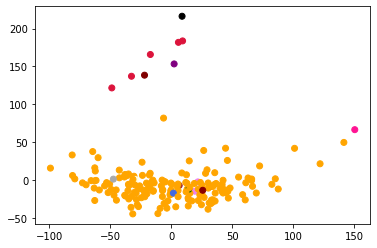

In [34]:
plt.scatter(yy[:,0], yy[:,1], c=color_labels)

We can see that most of the points are concentrated in the particular range of PC1 and PC2 values.
So we can separate the samples from Neuroendocrine and Exocrine.
The outliers are -75 < PC1 < 75. I choose this range as it is PC1 and more prominant feature. and other constraint is PC2 < 50. It will provide us to clearly seperate the outliers. So in next step, We'll remove the outlier samples from the dataframe. 

In [35]:
import pandas as pd
pp = pd.DataFrame(yy, columns=['PC1', 'PC2'], index=cid)
pp.head()

,PC1,PC2
aab1-Primary solid Tumor,19.377565,-14.983474
aab4-Primary solid Tumor,6.459735,-7.324437
aab6-Primary solid Tumor,22.107016,-12.287171
aab8-Primary solid Tumor,14.004171,-25.846382
aab9-Primary solid Tumor,-14.081426,-4.000464


In [36]:
indexNames = pp[ (pp['PC1'] < -75) | (pp['PC1'] > 75) | (pp['PC2'] > 50)].index
indexNames

Index(['aaqm-Primary solid Tumor', 'a9ij-Primary solid Tumor',
       'a9il-Primary solid Tumor', 'a9in-Primary solid Tumor',
       'a9io-Primary solid Tumor', 'a9ir-Primary solid Tumor',
       'a9is-Primary solid Tumor', 'a9iv-Primary solid Tumor',
       '6880-Primary solid Tumor', 'aapp-Primary solid Tumor',
       'aapu-Primary solid Tumor', 'aaq0-Primary solid Tumor',
       'a7op-Primary solid Tumor', '7289-Primary solid Tumor',
       '7920-Primary solid Tumor', '7923-Primary solid Tumor',
       '7897-Primary solid Tumor', 'aauv-Primary solid Tumor',
       'a776-Primary solid Tumor', 'a8lh-Primary solid Tumor'],
      dtype='object')

In [37]:
print('Number of Neuroendocrine Tumors are: {}'.format(len(indexNames)))

Number of Neuroendocrine Tumors are: 20


In [38]:
pp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, aab1-Primary solid Tumor to aapl-Primary solid Tumor
Data columns (total 2 columns):
PC1    183 non-null float32
PC2    183 non-null float32
dtypes: float32(2)
memory usage: 2.9+ KB


In [0]:
pp.drop(indexNames, inplace=True)

In [40]:
pp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 163 entries, aab1-Primary solid Tumor to aapl-Primary solid Tumor
Data columns (total 2 columns):
PC1    163 non-null float32
PC2    163 non-null float32
dtypes: float32(2)
memory usage: 2.5+ KB


Now, we know the samples, which fall in category of Pancreatic Adenocarcinoma, and we also know the genes responsible for type1 interferons (Type 1 IFN Signature). These genes are a set of 25 genes in homosapians.
So To plot the gene expression, for pancreatic adenocarcinoma, We'll create a dataframe with these 25 genes as rows and the Sample name (Which is the index of the pp dataframe.) as columns.

In [0]:
with open('/content/drive/My Drive/Colab Notebooks/data/type1_IFN.txt', 'r') as f:
    content = f.readlines()
content = [x.strip() for x in content]

In [0]:
# content

In [43]:
ifn1 = new_data_df.loc[content]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



In [44]:
ifn1.shape

(25, 183)

In [0]:
indexNames = indexNames.to_list()

In [46]:
indexNames

['aaqm-Primary solid Tumor',
 'a9ij-Primary solid Tumor',
 'a9il-Primary solid Tumor',
 'a9in-Primary solid Tumor',
 'a9io-Primary solid Tumor',
 'a9ir-Primary solid Tumor',
 'a9is-Primary solid Tumor',
 'a9iv-Primary solid Tumor',
 '6880-Primary solid Tumor',
 'aapp-Primary solid Tumor',
 'aapu-Primary solid Tumor',
 'aaq0-Primary solid Tumor',
 'a7op-Primary solid Tumor',
 '7289-Primary solid Tumor',
 '7920-Primary solid Tumor',
 '7923-Primary solid Tumor',
 '7897-Primary solid Tumor',
 'aauv-Primary solid Tumor',
 'a776-Primary solid Tumor',
 'a8lh-Primary solid Tumor']

In [0]:
ifn1 = ifn1.drop(indexNames, axis=1)

In [48]:
ifn1.shape

(25, 163)

# The plot of distribution of 25 genes (Type 1 IFN Signature):

The data I plotted here is of 25 genes and 163 samples (The samples which are Exocrine Type as we dropped those samples which were Neuroendocrine(20 samples)).

In [0]:
configure_plotly_browser_state()
import plotly.graph_objects as go
import plotly.offline as pyo
pyo.init_notebook_mode()

fig = go.Figure(data=go.Heatmap(
                   z=ifn1.values,
                   x=ifn1.columns,
                   y=ifn1.index,
                   hoverongaps = False))
fig.show()

### Image of the Type 1 IFN genes (25 genes) --> it's distribution across samples of Exocrine.

![gene_25](https://user-images.githubusercontent.com/36000962/75326741-2b709980-58a1-11ea-9891-5ef9725f59dc.png)

So, we can see the distribution of gene acorss different samples is like it has most values near 10, as the colour of heatmap near 10 is most likely observed. The yellow and blue have less frequency. So it signifies that a few values are around 14 and 4 respectively.

In [0]:
#Save the 25 gene and 163 sample dataframe in CSV format for further analysis.(For use in GSVA algorithm)
ifn1.to_csv('ifn1.csv')
!cp ifn1.csv "/content/drive/My Drive/Colab Notebooks/data/"

### The output from GSVA algorithm is shown as the screenshot from the command terminal. I ran this algorithm in Docker.

##### The file description is as following:
- **ifn1.csv:** This file has 25 gene and 163 sample data in CSV format.
- **ifn1_gmt_file.gmt:** This file is a GMT file which has the genes in tab separate values. *name </tab/> description </tab/> gene1 </tab/> gene2 </tab/> ... </tab/> geneN*
- **example_pathways.csv:** This file has output from the GSVA algorithm in CSV format.


![gsva](https://user-images.githubusercontent.com/36000962/75442862-4f59db00-5986-11ea-91ce-5ece6f0f7e54.png)
